In [1]:
import pandas as pd
import glob
import os
from pathlib import Path
import requests
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
import requests
from bs4 import BeautifulSoup
import pandas as pd
import zipfile
import json
from pandas import json_normalize

In [2]:
def read_and_filter_file(file_path):
    """
    Read a CSV file and filter out metadata rows.
    Metadata rows have values like 'RESULT_TYPE', 'RESULT_DESCR', etc. in the first column.
    """
    df = pd.read_csv(file_path, compression='gzip')

    metadata_keywords = [
        'RESULT_TYPE',
        'RESULT_DESCR',
        'RESULT_UNIT',
        'RESULT_IS_ACTIVE_CONCENTRATION',
        'RESULT_IS_ACTIVE_CONCENTRATION_QUALIFIER'
    ]
    
    # filter out rows where first column matches any metadata keyword
    df_filtered = df[~df[df.columns[0]].isin(metadata_keywords)]
    return df_filtered

In [3]:
folder_path = '0003001_0004000 5'

file_pattern = os.path.join(folder_path, '*.concise.csv.gz')
all_files = sorted(glob.glob(file_pattern))

print(f'Found {len(all_files)} files')
print(f'First file: {all_files[0]}')
print(f'Last file: {all_files[-1]}')

Found 1000 files
First file: 0003001_0004000 5/3001.concise.csv.gz
Last file: 0003001_0004000 5/4000.concise.csv.gz


In [4]:
all_files[0:5]

['0003001_0004000 5/3001.concise.csv.gz',
 '0003001_0004000 5/3002.concise.csv.gz',
 '0003001_0004000 5/3003.concise.csv.gz',
 '0003001_0004000 5/3004.concise.csv.gz',
 '0003001_0004000 5/3005.concise.csv.gz']

In [5]:
# read all files and concatenate into a single DataFrame
df_list = []

for i, file in enumerate(all_files):
    df = read_and_filter_file(file)
    df_list.append(df)
    
    if (i + 1) % 100 == 0:
        print(f'Processed {i + 1}/{len(all_files)} files...')

combined_df = pd.concat(df_list, ignore_index=True)

print(f"\n Combined DataFrame shape: {combined_df.shape}")
combined_df

Processed 100/1000 files...
Processed 200/1000 files...
Processed 300/1000 files...
Processed 400/1000 files...
Processed 500/1000 files...
Processed 600/1000 files...
Processed 700/1000 files...
Processed 800/1000 files...
Processed 900/1000 files...
Processed 1000/1000 files...

Combined DataFrame shape: (6628, 9)


,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PubChem Standard Value,PUBCHEM_ASSAYDATA_COMMENT
0,1,103191505.0,20039.0,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,NaN,NaN,200,NaN
1,2,103220966.0,64975.0,C1=C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,NaN,NaN,70,NaN
2,3,103225076.0,135841357.0,C1=CC(OC1CO)N2C=NC3=C2N=CNC3=O,Unspecified,NaN,NaN,50,NaN
3,4,103225564.0,135431125.0,C1=CC(OC1CO)N2C=NC3=C2N=C(NC3=O)N,Unspecified,NaN,NaN,50,NaN
4,5,103277154.0,135463029.0,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C2N=C(NC3=O)N,Unspecified,NaN,NaN,200,NaN
...,...,...,...,...,...,...,...,...,...
6623,8,160675538.0,14975318.0,COC1=CC=CC2=C1[C@@H]3CCN(C[C@H]3C2)CCCN4C(=O)C...,Active,NaN,NaN,0.0512,NaN
6624,9,160686181.0,14975310.0,CCCN1CC[C@@H]2[C@@H](C1)CC3=C2C(=CC=C3)OC,Active,NaN,NaN,0.0762,NaN
6625,10,160686182.0,14975317.0,COC1=CC=CC2=C1[C@@H]3CCN(C[C@@H]3C2)CCCN4C(=O)...,Active,NaN,NaN,0.692,NaN
6626,11,160691660.0,14975319.0,COC1=CC=CC2=C1[C@@H]3CCN(C[C@@H]3C2)CCCCN4C(=O...,Active,NaN,NaN,0.0545,NaN


In [6]:
combined_df['PUBCHEM_CID'].isnull().sum()

146

In [7]:
combined_df = combined_df[~combined_df['PUBCHEM_CID'].isnull()]

In [8]:
len(combined_df)

6482

In [9]:
combined_df['PUBCHEM_CID'] = combined_df['PUBCHEM_CID'].astype(int)

/var/folders/gw/6zvc4vx95yx8vrymkvc5m8zm0000gn/T/ipykernel_39986/4245810301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['PUBCHEM_CID'] = combined_df['PUBCHEM_CID'].astype(int)


In [10]:
combined_df

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PubChem Standard Value,PUBCHEM_ASSAYDATA_COMMENT
0,1,103191505.0,20039,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,NaN,NaN,200,NaN
1,2,103220966.0,64975,C1=C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,NaN,NaN,70,NaN
2,3,103225076.0,135841357,C1=CC(OC1CO)N2C=NC3=C2N=CNC3=O,Unspecified,NaN,NaN,50,NaN
3,4,103225564.0,135431125,C1=CC(OC1CO)N2C=NC3=C2N=C(NC3=O)N,Unspecified,NaN,NaN,50,NaN
4,5,103277154.0,135463029,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C2N=C(NC3=O)N,Unspecified,NaN,NaN,200,NaN
...,...,...,...,...,...,...,...,...,...
6623,8,160675538.0,14975318,COC1=CC=CC2=C1[C@@H]3CCN(C[C@H]3C2)CCCN4C(=O)C...,Active,NaN,NaN,0.0512,NaN
6624,9,160686181.0,14975310,CCCN1CC[C@@H]2[C@@H](C1)CC3=C2C(=CC=C3)OC,Active,NaN,NaN,0.0762,NaN
6625,10,160686182.0,14975317,COC1=CC=CC2=C1[C@@H]3CCN(C[C@@H]3C2)CCCN4C(=O)...,Active,NaN,NaN,0.692,NaN
6626,11,160691660.0,14975319,COC1=CC=CC2=C1[C@@H]3CCN(C[C@@H]3C2)CCCCN4C(=O...,Active,NaN,NaN,0.0545,NaN


In [11]:
combined_df.dtypes

PUBCHEM_RESULT_TAG                object
PUBCHEM_SID                      float64
PUBCHEM_CID                        int64
PUBCHEM_EXT_DATASOURCE_SMILES     object
PUBCHEM_ACTIVITY_OUTCOME          object
PUBCHEM_ACTIVITY_SCORE           float64
PUBCHEM_ACTIVITY_URL             float64
PubChem Standard Value            object
PUBCHEM_ASSAYDATA_COMMENT        float64
dtype: object

In [12]:
combined_df[combined_df['PUBCHEM_CID'] == 135841357]

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PubChem Standard Value,PUBCHEM_ASSAYDATA_COMMENT
2,3,103225076.0,135841357,C1=CC(OC1CO)N2C=NC3=C2N=CNC3=O,Unspecified,NaN,NaN,50,NaN


In [13]:
combined_df['PUBCHEM_EXT_DATASOURCE_SMILES'][0:5]

0     C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N
1    C1=C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N
2                C1=CC(OC1CO)N2C=NC3=C2N=CNC3=O
3             C1=CC(OC1CO)N2C=NC3=C2N=C(NC3=O)N
4    C1C[C@@H](O[C@@H]1CO)N2C=NC3=C2N=C(NC3=O)N
Name: PUBCHEM_EXT_DATASOURCE_SMILES, dtype: object

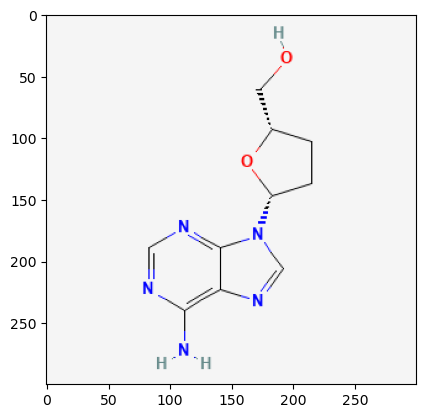

In [14]:
url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N/PNG"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)

In [16]:
url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/20039/JSON/"

response = requests.get(url).json()
response['Record']['RecordNumber']

20039

In [17]:
# response['Record']['Section']#['TOCHeading' == 'Safety and Hazards']

In [18]:
sections = response['Record']['Section']

safety_section = None
for sec in sections:
    if sec.get("TOCHeading") == "Safety and Hazards":
        safety_section = sec
        break


In [19]:
safety_section['Section'][0]['Section'][0]['Information'][2]['Value']['StringWithMarkup']

[{'String': 'H315 (50%): Causes skin irritation [Warning Skin corrosion/irritation]',
  'Markup': [{'Start': 36,
    'Length': 7,
    'Type': 'Color',
    'Extra': 'GHSWarning'}]},
 {'String': 'H319 (50%): Causes serious eye irritation [Warning Serious eye damage/eye irritation]',
  'Markup': [{'Start': 43,
    'Length': 7,
    'Type': 'Color',
    'Extra': 'GHSWarning'}]},
 {'String': 'H335 (50%): May cause respiratory irritation [Warning Specific target organ toxicity, single exposure; Respiratory tract irritation]',
  'Markup': [{'Start': 46,
    'Length': 7,
    'Type': 'Color',
    'Extra': 'GHSWarning'}]},
 {'String': 'H341 (50%): Suspected of causing genetic defects [Warning Germ cell mutagenicity]',
  'Markup': [{'Start': 50,
    'Length': 7,
    'Type': 'Color',
    'Extra': 'GHSWarning'}]}]

In [20]:
haz_list = safety_section['Section'][0]['Section'][0]['Information'][2]['Value']['StringWithMarkup']
haz = [item['String'] for item in haz_list]
haz

['H315 (50%): Causes skin irritation [Warning Skin corrosion/irritation]',
 'H319 (50%): Causes serious eye irritation [Warning Serious eye damage/eye irritation]',
 'H335 (50%): May cause respiratory irritation [Warning Specific target organ toxicity, single exposure; Respiratory tract irritation]',
 'H341 (50%): Suspected of causing genetic defects [Warning Germ cell mutagenicity]']

In [21]:
len(safety_section['Section'][0]['Section'][0]['Information'][2]['Value']['StringWithMarkup'])

4

In [22]:
hazards = []
for i in range(0, len(safety_section['Section'][0]['Section'][0]['Information'][2]['Value']['StringWithMarkup'])):
    haz = safety_section['Section'][0]['Section'][0]['Information'][2]['Value']['StringWithMarkup'][i]['String']
    hazards.append(haz)

In [23]:
hazards

['H315 (50%): Causes skin irritation [Warning Skin corrosion/irritation]',
 'H319 (50%): Causes serious eye irritation [Warning Serious eye damage/eye irritation]',
 'H335 (50%): May cause respiratory irritation [Warning Specific target organ toxicity, single exposure; Respiratory tract irritation]',
 'H341 (50%): Suspected of causing genetic defects [Warning Germ cell mutagenicity]']

In [24]:
cid_list = combined_df['PUBCHEM_CID'].tolist()
dic = {'PUBCHEM_CID': [],
      'Hazards': []}

for cid in cid_list:
    print(f'Starting on CID number {cid}')
    url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/{cid}/JSON/'
    response = requests.get(url).json()
    cid_num = response['Record']['RecordNumber']
    dic['PUBCHEM_CID'].append(cid_num)

    try:
        sections = response['Record']['Section']
        safety_section = None
        for sec in sections:
            if sec.get("TOCHeading") == "Safety and Hazards":
                safety_section = sec
                haz_list = safety_section['Section'][0]['Section'][0]['Information'][2]['Value']['StringWithMarkup']
                haz = [item['String'] for item in haz_list]
                dic['Hazards'].append(haz)
    except (KeyError, IndexError, StopIteration):
        dic['Hazards'].append([])
        print(f"No hazards info found for CID {cid}, skipping.")

rows = []
for cid, hazard in zip(dic['PUBCHEM_CID'], dic['Hazards']):
    for h in hazard:
        rows.append({'PUBCHEM_CID': cid, 'Hazard': h})

hazards_df = pd.DataFrame(rows)

Starting on CID number 20039
Starting on CID number 64975
Starting on CID number 135841357
Starting on CID number 135431125
Starting on CID number 135463029
Starting on CID number 135398739
Starting on CID number 24066
Starting on CID number 44351660
Starting on CID number 5271785
Starting on CID number 135410302
Starting on CID number 44366984
Starting on CID number 44366985
Starting on CID number 44367130
Starting on CID number 44367131
Starting on CID number 44367159
Starting on CID number 44367171
Starting on CID number 44367172
Starting on CID number 44367173
Starting on CID number 44367177
Starting on CID number 44367178
Starting on CID number 44367179
Starting on CID number 44367329
Starting on CID number 135841589
Starting on CID number 50312
Starting on CID number 72327
Starting on CID number 151382
Starting on CID number 6474729
Starting on CID number 5270568
Starting on CID number 11849876
Starting on CID number 6480472
Starting on CID number 466424
Starting on CID number 46

Starting on CID number 44339859
Starting on CID number 44339860
Starting on CID number 44340114
Starting on CID number 44340115
Starting on CID number 44340290
Starting on CID number 44340291
Starting on CID number 44340292
Starting on CID number 469717
Starting on CID number 72413
Starting on CID number 470881
Starting on CID number 60877
Starting on CID number 455271
Starting on CID number 64683
Starting on CID number 469717
Starting on CID number 72413
Starting on CID number 60877
Starting on CID number 455271
Starting on CID number 64683
Starting on CID number 10319782
Starting on CID number 10023940
Starting on CID number 657378
Starting on CID number 135398735
Starting on CID number 136109130
Starting on CID number 44283522
Starting on CID number 14589480
Starting on CID number 44283541
Starting on CID number 11072843
Starting on CID number 135398735
Starting on CID number 44283413
Starting on CID number 44283542
Starting on CID number 44283413
Starting on CID number 136109130
St

Starting on CID number 369332
Starting on CID number 474873
Starting on CID number 369333
Starting on CID number 6918663
Starting on CID number 636403
No hazards info found for CID 636403, skipping.
Starting on CID number 6918650
Starting on CID number 6918650
Starting on CID number 6918663
Starting on CID number 636403
No hazards info found for CID 636403, skipping.
Starting on CID number 6918663
Starting on CID number 636403
No hazards info found for CID 636403, skipping.
Starting on CID number 6918650
Starting on CID number 6918650
Starting on CID number 44299092
Starting on CID number 44299093
Starting on CID number 44299094
Starting on CID number 135918
Starting on CID number 11356288
Starting on CID number 161210
Starting on CID number 4174
Starting on CID number 44299128
Starting on CID number 44299129
Starting on CID number 238335
Starting on CID number 44299138
Starting on CID number 44299142
Starting on CID number 44299143
Starting on CID number 44299144
Starting on CID numbe

Starting on CID number 45261550
Starting on CID number 45261573
Starting on CID number 45264876
Starting on CID number 45261487
Starting on CID number 45261494
Starting on CID number 45261497
Starting on CID number 45261513
Starting on CID number 45261516
Starting on CID number 45261528
Starting on CID number 45261480
Starting on CID number 45261487
Starting on CID number 45261491
Starting on CID number 45261493
Starting on CID number 45261494
Starting on CID number 45261497
Starting on CID number 45261503
Starting on CID number 45261512
Starting on CID number 45261513
Starting on CID number 45261516
Starting on CID number 45261517
Starting on CID number 45261528
Starting on CID number 45261539
Starting on CID number 45261550
Starting on CID number 45261573
Starting on CID number 45264876
Starting on CID number 135407589
Starting on CID number 135616222
Starting on CID number 135407589
Starting on CID number 135616222
Starting on CID number 136191404
Starting on CID number 135616221
St

Starting on CID number 44373813
Starting on CID number 44373816
Starting on CID number 44373313
Starting on CID number 44373481
Starting on CID number 44373552
Starting on CID number 44373584
Starting on CID number 44373613
Starting on CID number 44373623
Starting on CID number 44373613
Starting on CID number 44373313
Starting on CID number 44373313
Starting on CID number 44373413
Starting on CID number 44373422
Starting on CID number 44373481
Starting on CID number 44373481
Starting on CID number 44373490
Starting on CID number 44373552
Starting on CID number 44373572
Starting on CID number 44373584
Starting on CID number 44373584
Starting on CID number 44373613
Starting on CID number 44373623
Starting on CID number 44373623
Starting on CID number 44373642
Starting on CID number 5202
Starting on CID number 5202
Starting on CID number 15681421
Starting on CID number 15681444
Starting on CID number 15681424
Starting on CID number 15681426
Starting on CID number 15681442
Starting on CID 

Starting on CID number 9977262
Starting on CID number 44290480
Starting on CID number 44290487
Starting on CID number 44290488
Starting on CID number 44290489
Starting on CID number 44290517
Starting on CID number 44290531
Starting on CID number 44290532
Starting on CID number 9874938
Starting on CID number 44290713
Starting on CID number 44290714
Starting on CID number 44290769
Starting on CID number 5920
Starting on CID number 289
Starting on CID number 10354627
Starting on CID number 72
Starting on CID number 10106750
Starting on CID number 11820665
Starting on CID number 289
Starting on CID number 10354627
Starting on CID number 72
Starting on CID number 10106750
Starting on CID number 11820665
Starting on CID number 289
Starting on CID number 289
Starting on CID number 2556
Starting on CID number 44277278
Starting on CID number 44277306
Starting on CID number 44387186
Starting on CID number 2556
Starting on CID number 44277278
Starting on CID number 44277306
Starting on CID number

Starting on CID number 73355711
Starting on CID number 44346953
Starting on CID number 3706633
Starting on CID number 73346603
Starting on CID number 73355711
Starting on CID number 73355712
Starting on CID number 45261690
Starting on CID number 45261691
Starting on CID number 45261756
Starting on CID number 45265002
Starting on CID number 45265038
Starting on CID number 73346603
Starting on CID number 73355711
Starting on CID number 73355712
Starting on CID number 44346953
Starting on CID number 3706633
Starting on CID number 45261690
Starting on CID number 45261691
Starting on CID number 45261756
Starting on CID number 45265002
Starting on CID number 45265038
Starting on CID number 73346603
Starting on CID number 73352668
Starting on CID number 73355711
Starting on CID number 73355712
Starting on CID number 44346953
Starting on CID number 3706633
Starting on CID number 45261690
Starting on CID number 45261691
Starting on CID number 45261756
Starting on CID number 45265002
Starting on

Starting on CID number 44359129
Starting on CID number 44359136
Starting on CID number 9988765
Starting on CID number 44359203
Starting on CID number 10441206
Starting on CID number 10034116
Starting on CID number 10396384
Starting on CID number 71459894
Starting on CID number 10260590
Starting on CID number 73347038
Starting on CID number 44359137
Starting on CID number 10057033
Starting on CID number 10441327
Starting on CID number 44358776
Starting on CID number 44358777
Starting on CID number 10057031
Starting on CID number 10079875
Starting on CID number 44358832
Starting on CID number 44358844
Starting on CID number 10011511
Starting on CID number 10034143
Starting on CID number 10463866
Starting on CID number 10034153
Starting on CID number 44359129
Starting on CID number 44359136
Starting on CID number 9988765
Starting on CID number 44359203
Starting on CID number 10034116
Starting on CID number 10396384
Starting on CID number 71459894
Starting on CID number 10260590
Starting o

Starting on CID number 44362652
Starting on CID number 44362652
Starting on CID number 44362847
Starting on CID number 10647800
Starting on CID number 44363026
Starting on CID number 44362455
Starting on CID number 44363026
Starting on CID number 44362973
Starting on CID number 44362413
Starting on CID number 44362439
Starting on CID number 44362440
Starting on CID number 44362441
Starting on CID number 44362455
Starting on CID number 44362456
Starting on CID number 44362469
Starting on CID number 44362639
Starting on CID number 44362639
Starting on CID number 44362652
Starting on CID number 44362652
Starting on CID number 44362680
Starting on CID number 44362684
Starting on CID number 44362684
Starting on CID number 10546075
Starting on CID number 10546075
Starting on CID number 44362712
Starting on CID number 44362747
Starting on CID number 10735047
Starting on CID number 44362767
Starting on CID number 44362767
Starting on CID number 10314747
Starting on CID number 10767254
Starting

Starting on CID number 10549616
Starting on CID number 10673545
Starting on CID number 11743669
Starting on CID number 77999
Starting on CID number 10363029
Starting on CID number 10361336
Starting on CID number 10363902
Starting on CID number 9978035
Starting on CID number 10388918
Starting on CID number 11742116
Starting on CID number 10023479
Starting on CID number 77999
Starting on CID number 5591
Starting on CID number 4829
Starting on CID number 10788309
Starting on CID number 10763236
Starting on CID number 9866203
Starting on CID number 10763146
Starting on CID number 10665557
Starting on CID number 22013881
Starting on CID number 10573498
Starting on CID number 9953271
Starting on CID number 10788402
Starting on CID number 11797860
Starting on CID number 10550935
Starting on CID number 10524496
Starting on CID number 10641668
Starting on CID number 10023542
Starting on CID number 10522854
Starting on CID number 154000
Starting on CID number 10574939
Starting on CID number 6918

Starting on CID number 44315753
Starting on CID number 44315755
Starting on CID number 44315756
Starting on CID number 44315757
Starting on CID number 44315764
Starting on CID number 44315806
Starting on CID number 44315819
Starting on CID number 44315837
Starting on CID number 44315875
Starting on CID number 44315908
Starting on CID number 44315909
Starting on CID number 44315930
Starting on CID number 44315969
Starting on CID number 44315970
Starting on CID number 44315992
Starting on CID number 44316011
Starting on CID number 44316012
Starting on CID number 44316013
Starting on CID number 44316040
Starting on CID number 44316043
Starting on CID number 44316054
Starting on CID number 44316062
Starting on CID number 44316075
Starting on CID number 44316076
Starting on CID number 44316077
Starting on CID number 44316078
Starting on CID number 68741
Starting on CID number 46905116
Starting on CID number 10411536
Starting on CID number 6917653
Starting on CID number 44315430
Starting on 

Starting on CID number 10777682
Starting on CID number 10516340
Starting on CID number 10590206
Starting on CID number 10569470
Starting on CID number 10496957
Starting on CID number 10687868
Starting on CID number 10689339
Starting on CID number 10523090
Starting on CID number 10737848
Starting on CID number 10809561
Starting on CID number 10665419
Starting on CID number 10502452
Starting on CID number 10568666
Starting on CID number 44306007
Starting on CID number 10645615
Starting on CID number 10811876
Starting on CID number 11793287
Starting on CID number 10852612
Starting on CID number 10590360
Starting on CID number 10833258
Starting on CID number 10717512
Starting on CID number 10621131
Starting on CID number 135398737
Starting on CID number 3559
Starting on CID number 10759541
Starting on CID number 10547091
Starting on CID number 10522029
Starting on CID number 10645076
Starting on CID number 10809238
Starting on CID number 10717072
Starting on CID number 10573576
Starting on

Starting on CID number 10332122
Starting on CID number 10446088
Starting on CID number 10401705
Starting on CID number 10423337
Starting on CID number 10424079
Starting on CID number 44374236
Starting on CID number 10378503
Starting on CID number 10038966
Starting on CID number 10445991
Starting on CID number 10061032
Starting on CID number 22864491
Starting on CID number 10015438
Starting on CID number 10466960
Starting on CID number 10355844
Starting on CID number 10015338
Starting on CID number 9991334
Starting on CID number 10466294
Starting on CID number 10332803
Starting on CID number 10244325
Starting on CID number 10400539
Starting on CID number 10422091
Starting on CID number 10263220
Starting on CID number 9970622
Starting on CID number 10264555
Starting on CID number 10264556
Starting on CID number 10445902
Starting on CID number 22864495
Starting on CID number 10084026
Starting on CID number 10266873
Starting on CID number 10038106
Starting on CID number 10037437
Starting o

Starting on CID number 44335519
Starting on CID number 9929572
Starting on CID number 9820163
Starting on CID number 10271949
Starting on CID number 44335674
Starting on CID number 9842682
Starting on CID number 10272986
Starting on CID number 9975609
Starting on CID number 11303781
Starting on CID number 11484260
Starting on CID number 11313754
Starting on CID number 5684
Starting on CID number 11246169
Starting on CID number 9798593
Starting on CID number 11232913
Starting on CID number 10362715
Starting on CID number 10090661
Starting on CID number 11280199
Starting on CID number 9885700
Starting on CID number 11164569
Starting on CID number 11739995
Starting on CID number 11485068
Starting on CID number 11394411
Starting on CID number 11221557
Starting on CID number 9862968
Starting on CID number 11382841
Starting on CID number 11381753
Starting on CID number 3386
Starting on CID number 11175450
Starting on CID number 11428089
Starting on CID number 11313610
Starting on CID number 

Starting on CID number 44335674
Starting on CID number 10111229
Starting on CID number 44335519
Starting on CID number 9929572
Starting on CID number 9820163
Starting on CID number 44335674
Starting on CID number 10271949
Starting on CID number 10272986
Starting on CID number 10271949
Starting on CID number 9842682
Starting on CID number 9842337
Starting on CID number 9975609
Starting on CID number 9842682
Starting on CID number 10272986
Starting on CID number 11048769
Starting on CID number 11059058
Starting on CID number 10885636
Starting on CID number 10894144
Starting on CID number 11113605
Starting on CID number 11071079
Starting on CID number 11005810
Starting on CID number 9798593
Starting on CID number 59022
Starting on CID number 26395
Starting on CID number 14011045
Starting on CID number 169764
Starting on CID number 44362284
Starting on CID number 9847194
Starting on CID number 11394095
Starting on CID number 2477
Starting on CID number 10406539
Starting on CID number 10319

Starting on CID number 135515412
Starting on CID number 135827489
Starting on CID number 135827496
Starting on CID number 135827483
Starting on CID number 135827493
Starting on CID number 136056465
Starting on CID number 135827488
Starting on CID number 135827481
Starting on CID number 135827486
Starting on CID number 135827492
Starting on CID number 135827497
Starting on CID number 135827490
Starting on CID number 136056461
Starting on CID number 136056462
Starting on CID number 136056464
Starting on CID number 135827485
Starting on CID number 135827487
Starting on CID number 135827491
Starting on CID number 135827484
Starting on CID number 136056463
Starting on CID number 135827495
Starting on CID number 12292503
Starting on CID number 135696763
Starting on CID number 136056466
Starting on CID number 44385993
Starting on CID number 60490
Starting on CID number 56237
Starting on CID number 130007
Starting on CID number 160268
Starting on CID number 59757
Starting on CID number 4534
St

Starting on CID number 4595
Starting on CID number 1346
Starting on CID number 70530
Starting on CID number 4296
Starting on CID number 13599009
Starting on CID number 796570
Starting on CID number 13599004
Starting on CID number 1074765
Starting on CID number 44372211
Starting on CID number 3699556
Starting on CID number 4738744
Starting on CID number 2758473
Starting on CID number 13599019
Starting on CID number 13599017
Starting on CID number 2760448
Starting on CID number 3007
Starting on CID number 4184
No hazards info found for CID 4184, skipping.
Starting on CID number 62065
No hazards info found for CID 62065, skipping.
Starting on CID number 1833
Starting on CID number 5202
Starting on CID number 1832
Starting on CID number 31014
Starting on CID number 105432
Starting on CID number 85875
No hazards info found for CID 85875, skipping.
Starting on CID number 542051
Starting on CID number 3822
Starting on CID number 27402
Starting on CID number 23844155
Starting on CID number 627

Starting on CID number 45259326
Starting on CID number 45259329
Starting on CID number 45259331
Starting on CID number 45263941
Starting on CID number 45263983
Starting on CID number 3022645
No hazards info found for CID 3022645, skipping.
Starting on CID number 5656
Starting on CID number 4205
Starting on CID number 4020
Starting on CID number 4500
Starting on CID number 44367421
Starting on CID number 11371751
Starting on CID number 44367469
Starting on CID number 11361911
Starting on CID number 44367489
Starting on CID number 11360189
Starting on CID number 11301347
Starting on CID number 1548970
Starting on CID number 11162476
Starting on CID number 11232302
Starting on CID number 11174064
Starting on CID number 9926786
Starting on CID number 11165181
Starting on CID number 11409374
Starting on CID number 11189958
Starting on CID number 11176855
Starting on CID number 11270036
Starting on CID number 11270558
Starting on CID number 11259979
Starting on CID number 11164814
Starting o

Starting on CID number 11743327
Starting on CID number 3082597
Starting on CID number 3082597
Starting on CID number 3082597
Starting on CID number 131001
Starting on CID number 10338595
Starting on CID number 10014217
Starting on CID number 9975915
Starting on CID number 10105405
Starting on CID number 24833969
Starting on CID number 24833969
Starting on CID number 24833969
Starting on CID number 24833968
Starting on CID number 44295483
Starting on CID number 44295508
Starting on CID number 44295541
Starting on CID number 24834878
Starting on CID number 44295587
Starting on CID number 44295679
Starting on CID number 44295679
Starting on CID number 44295679
Starting on CID number 44295706
Starting on CID number 10008462
Starting on CID number 44295780
Starting on CID number 19023740
Starting on CID number 19023740
Starting on CID number 19023740
Starting on CID number 44295874
Starting on CID number 44295874
Starting on CID number 44295874
Starting on CID number 44295875
Starting on CI

Starting on CID number 10862446
Starting on CID number 11143739
Starting on CID number 11003766
Starting on CID number 11069992
Starting on CID number 10873343
Starting on CID number 11049024
Starting on CID number 11059579
Starting on CID number 10862911
Starting on CID number 11059222
Starting on CID number 10892936
Starting on CID number 2477
Starting on CID number 1220
Starting on CID number 10385977
Starting on CID number 10001519
Starting on CID number 10474042
Starting on CID number 10453320
Starting on CID number 10361439
Starting on CID number 10248163
Starting on CID number 10092041
Starting on CID number 10021562
Starting on CID number 10406366
Starting on CID number 192639
Starting on CID number 10408398
Starting on CID number 10384067
Starting on CID number 10090269
Starting on CID number 11742092
Starting on CID number 10070289
Starting on CID number 10070045
Starting on CID number 10475634
Starting on CID number 10250792
Starting on CID number 10067369
Starting on CID nu

Starting on CID number 5202
Starting on CID number 9870500
Starting on CID number 11307899
Starting on CID number 60857
Starting on CID number 1220
Starting on CID number 44316740
Starting on CID number 44316755
Starting on CID number 44316789
Starting on CID number 44316790
Starting on CID number 10410577
Starting on CID number 44316815
Starting on CID number 44316963
Starting on CID number 44316964
Starting on CID number 44316965
Starting on CID number 44316966
Starting on CID number 44317057
Starting on CID number 44317081
Starting on CID number 44317082
Starting on CID number 44317084
Starting on CID number 44317095
Starting on CID number 44317120
Starting on CID number 44317121
Starting on CID number 44317134
Starting on CID number 44317146
Starting on CID number 44316828
Starting on CID number 44317084
Starting on CID number 44317107
Starting on CID number 44317147
Starting on CID number 44317148
Starting on CID number 4893
Starting on CID number 60149
Starting on CID number 4106

Starting on CID number 11384983
Starting on CID number 11453476
Starting on CID number 9867138
Starting on CID number 9887458
Starting on CID number 9802999
Starting on CID number 11350440
Starting on CID number 11487449
Starting on CID number 11464777
Starting on CID number 11154198
Starting on CID number 11339351
Starting on CID number 11176459
Starting on CID number 9822812
Starting on CID number 11177467
Starting on CID number 11418949
Starting on CID number 11304135
Starting on CID number 11474152
Starting on CID number 11200086
Starting on CID number 11189412
Starting on CID number 11348796
Starting on CID number 9845172
Starting on CID number 11474564
Starting on CID number 11303253
Starting on CID number 11325675
Starting on CID number 12840734
Starting on CID number 9929277
Starting on CID number 11268507
Starting on CID number 10407753
Starting on CID number 44300018
Starting on CID number 11211017
Starting on CID number 12840735
Starting on CID number 11191047
Starting on CI

Starting on CID number 11068036
Starting on CID number 10872581
Starting on CID number 11011968
Starting on CID number 11824522
Starting on CID number 10971452
Starting on CID number 11056946
Starting on CID number 11046087
Starting on CID number 11824009
Starting on CID number 11727140
Starting on CID number 10946905
Starting on CID number 10926112
Starting on CID number 5358
Starting on CID number 60857
Starting on CID number 9832057
Starting on CID number 5358
Starting on CID number 5078
Starting on CID number 10376578
Starting on CID number 4440
Starting on CID number 77992
No hazards info found for CID 77992, skipping.
Starting on CID number 28693
Starting on CID number 148842
Starting on CID number 10974101
Starting on CID number 10348924
Starting on CID number 11039289
Starting on CID number 10394346
Starting on CID number 1342
Starting on CID number 44351656
Starting on CID number 44351692
Starting on CID number 10649124
Starting on CID number 10601619
Starting on CID number 99

Starting on CID number 44290346
Starting on CID number 10550911
Starting on CID number 10692801
Starting on CID number 10718870
Starting on CID number 10765698
Starting on CID number 9865384
Starting on CID number 10764513
Starting on CID number 10835365
Starting on CID number 10025854
Starting on CID number 10600032
Starting on CID number 10528303
Starting on CID number 10647622
Starting on CID number 10742699
Starting on CID number 10646934
Starting on CID number 10743303
Starting on CID number 10813865
Starting on CID number 10694660
Starting on CID number 10647006
Starting on CID number 10718220
Starting on CID number 10694238
Starting on CID number 10647621
Starting on CID number 9802369
Starting on CID number 10789756
Starting on CID number 10812183
Starting on CID number 11795765
Starting on CID number 10695466
Starting on CID number 10694239
Starting on CID number 10695395
Starting on CID number 10740939
Starting on CID number 21797090
Starting on CID number 10812148
Starting o

Starting on CID number 11797166
Starting on CID number 10341805
Starting on CID number 10716504
Starting on CID number 11797049
Starting on CID number 10669552
Starting on CID number 10694821
Starting on CID number 10500912
Starting on CID number 10646494
Starting on CID number 10572792
Starting on CID number 10597962
Starting on CID number 11795852
Starting on CID number 10620723
Starting on CID number 10597700
Starting on CID number 10575339
Starting on CID number 10717656
Starting on CID number 9844458
Starting on CID number 5202
Starting on CID number 44351288
Starting on CID number 44351288
Starting on CID number 44351289
Starting on CID number 44351289
Starting on CID number 44351463
Starting on CID number 44351463
Starting on CID number 44351485
Starting on CID number 44351485
Starting on CID number 44351533
Starting on CID number 44351288
Starting on CID number 44351289
Starting on CID number 44351463
Starting on CID number 44351288
Starting on CID number 44351289
Starting on C

Starting on CID number 14162476
Starting on CID number 14566700
Starting on CID number 14566703
Starting on CID number 14566697
Starting on CID number 14566698
Starting on CID number 44300741
Starting on CID number 44300742
Starting on CID number 14566720
Starting on CID number 14566704
Starting on CID number 14566705
Starting on CID number 2477
Starting on CID number 1220
Starting on CID number 9907305
Starting on CID number 44269068
Starting on CID number 44269070
Starting on CID number 54587604
Starting on CID number 192260
Starting on CID number 14975318
Starting on CID number 14975310
Starting on CID number 14975317
Starting on CID number 14975319
Starting on CID number 14975320


In [25]:
hazards_df

,PUBCHEM_CID,Hazard
0,20039,H315 (50%): Causes skin irritation [Warning Sk...
1,20039,H319 (50%): Causes serious eye irritation [War...
2,20039,H335 (50%): May cause respiratory irritation [...
3,20039,H341 (50%): Suspected of causing genetic defec...
4,64975,H315 (25%): Causes skin irritation [Warning Sk...
...,...,...
1290,44329459,H319 (97.5%): Causes serious eye irritation [W...
1291,44329459,H335 (100%): May cause respiratory irritation ...
1292,44329497,Warning
1293,44329498,H332 (95.1%): Harmful if inhaled [Warning Acut...


In [26]:
hazards_df.to_csv('hazards_csv', index=False)

In [28]:
url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/20039/property/MolecularWeight,MolecularFormula,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,IsotopeAtomCount,/CSV'

properties = pd.read_csv(url)
properties

,CID,MolecularWeight,MolecularFormula,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,IsotopeAtomCount
0,20039,235.24,C10H13N5O2,2,6,2,17,0


In [31]:
all_properties = []

for cid in cid_list:
    print(f'Starting on CID number {cid}')
    url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/MolecularWeight,MolecularFormula,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,IsotopeAtomCount,/CSV'
    try:
        properties = pd.read_csv(url)
        all_properties.append(properties)
    except Exception as e:
        print(f"Failed to fetch CID {cid}: {e}")

properties_df = pd.concat(all_properties, ignore_index=True)

Starting on CID number 20039
Starting on CID number 64975
Starting on CID number 135841357
Starting on CID number 135431125
Starting on CID number 135463029
Starting on CID number 135398739
Starting on CID number 24066
Starting on CID number 44351660
Starting on CID number 5271785
Starting on CID number 135410302
Starting on CID number 44366984
Starting on CID number 44366985
Starting on CID number 44367130
Starting on CID number 44367131
Starting on CID number 44367159
Starting on CID number 44367171
Starting on CID number 44367172
Starting on CID number 44367173
Starting on CID number 44367177
Starting on CID number 44367178
Starting on CID number 44367179
Starting on CID number 44367329
Starting on CID number 135841589
Starting on CID number 50312
Starting on CID number 72327
Starting on CID number 151382
Starting on CID number 6474729
Starting on CID number 5270568
Starting on CID number 11849876
Starting on CID number 6480472
Starting on CID number 466424
Starting on CID number 46

Starting on CID number 44339860
Starting on CID number 44340114
Starting on CID number 44340115
Starting on CID number 44340290
Starting on CID number 44340291
Starting on CID number 44340292
Starting on CID number 469717
Starting on CID number 72413
Starting on CID number 470881
Starting on CID number 60877
Starting on CID number 455271
Starting on CID number 64683
Starting on CID number 469717
Starting on CID number 72413
Starting on CID number 60877
Starting on CID number 455271
Starting on CID number 64683
Starting on CID number 10319782
Starting on CID number 10023940
Starting on CID number 657378
Starting on CID number 135398735
Starting on CID number 136109130
Starting on CID number 44283522
Starting on CID number 14589480
Starting on CID number 44283541
Starting on CID number 11072843
Starting on CID number 135398735
Starting on CID number 44283413
Starting on CID number 44283542
Starting on CID number 44283413
Starting on CID number 136109130
Starting on CID number 44283522
St

Starting on CID number 6918663
Starting on CID number 636403
Starting on CID number 6918650
Starting on CID number 6918650
Starting on CID number 6918663
Starting on CID number 636403
Starting on CID number 6918663
Starting on CID number 636403
Starting on CID number 6918650
Starting on CID number 6918650
Starting on CID number 44299092
Starting on CID number 44299093
Starting on CID number 44299094
Starting on CID number 135918
Starting on CID number 11356288
Starting on CID number 161210
Starting on CID number 4174
Starting on CID number 44299128
Starting on CID number 44299129
Starting on CID number 238335
Starting on CID number 44299138
Starting on CID number 44299142
Starting on CID number 44299143
Starting on CID number 44299144
Starting on CID number 44299179
Starting on CID number 13663022
Starting on CID number 53001
Starting on CID number 53555
Starting on CID number 194468
Starting on CID number 792486
Starting on CID number 13594156
Starting on CID number 13594155
Starting 

Starting on CID number 45261528
Starting on CID number 45261480
Starting on CID number 45261487
Starting on CID number 45261491
Starting on CID number 45261493
Starting on CID number 45261494
Starting on CID number 45261497
Starting on CID number 45261503
Starting on CID number 45261512
Starting on CID number 45261513
Starting on CID number 45261516
Starting on CID number 45261517
Starting on CID number 45261528
Starting on CID number 45261539
Starting on CID number 45261550
Starting on CID number 45261573
Starting on CID number 45264876
Starting on CID number 135407589
Starting on CID number 135616222
Starting on CID number 135407589
Starting on CID number 135616222
Starting on CID number 136191404
Starting on CID number 135616221
Starting on CID number 135616222
Starting on CID number 135407589
Starting on CID number 135502131
Starting on CID number 135402008
Starting on CID number 135502124
Starting on CID number 135414024
Starting on CID number 135502131
Starting on CID number 1354

Starting on CID number 44373613
Starting on CID number 44373313
Starting on CID number 44373313
Starting on CID number 44373413
Starting on CID number 44373422
Starting on CID number 44373481
Starting on CID number 44373481
Starting on CID number 44373490
Starting on CID number 44373552
Starting on CID number 44373572
Starting on CID number 44373584
Starting on CID number 44373584
Starting on CID number 44373613
Starting on CID number 44373623
Starting on CID number 44373623
Starting on CID number 44373642
Starting on CID number 5202
Starting on CID number 5202
Starting on CID number 15681421
Starting on CID number 15681444
Starting on CID number 15681424
Starting on CID number 15681426
Starting on CID number 15681442
Starting on CID number 15681439
Starting on CID number 5191
Starting on CID number 15681444
Starting on CID number 15681439
Starting on CID number 4595
Starting on CID number 6918107
Starting on CID number 119376
Starting on CID number 121881
Starting on CID number 443075

Starting on CID number 9874938
Starting on CID number 44290713
Starting on CID number 44290714
Starting on CID number 44290769
Starting on CID number 5920
Starting on CID number 289
Starting on CID number 10354627
Starting on CID number 72
Starting on CID number 10106750
Starting on CID number 11820665
Starting on CID number 289
Starting on CID number 10354627
Starting on CID number 72
Starting on CID number 10106750
Starting on CID number 11820665
Starting on CID number 289
Starting on CID number 289
Starting on CID number 2556
Starting on CID number 44277278
Starting on CID number 44277306
Starting on CID number 44387186
Starting on CID number 2556
Starting on CID number 44277278
Starting on CID number 44277306
Starting on CID number 2556
Starting on CID number 44277278
Starting on CID number 44277306
Starting on CID number 2556
Starting on CID number 44277278
Starting on CID number 44277306
Starting on CID number 23686474
Starting on CID number 23668421
Starting on CID number 443031

Starting on CID number 45261756
Starting on CID number 45265002
Starting on CID number 45265038
Starting on CID number 73346603
Starting on CID number 73355711
Starting on CID number 73355712
Starting on CID number 44346953
Starting on CID number 3706633
Starting on CID number 45261690
Starting on CID number 45261691
Starting on CID number 45261756
Starting on CID number 45265002
Starting on CID number 45265038
Starting on CID number 73346603
Starting on CID number 73352668
Starting on CID number 73355711
Starting on CID number 73355712
Starting on CID number 44346953
Starting on CID number 3706633
Starting on CID number 45261690
Starting on CID number 45261691
Starting on CID number 45261756
Starting on CID number 45265002
Starting on CID number 45265038
Starting on CID number 73346603
Starting on CID number 73352668
Starting on CID number 73355711
Starting on CID number 73355712
Starting on CID number 73355712
Starting on CID number 45265038
Starting on CID number 45261690
Starting o

Starting on CID number 10260590
Starting on CID number 73347038
Starting on CID number 44359137
Starting on CID number 10057033
Starting on CID number 10441327
Starting on CID number 44358776
Starting on CID number 44358777
Starting on CID number 10057031
Starting on CID number 10079875
Starting on CID number 44358832
Starting on CID number 44358844
Starting on CID number 10011511
Starting on CID number 10034143
Starting on CID number 10463866
Starting on CID number 10034153
Starting on CID number 44359129
Starting on CID number 44359136
Starting on CID number 9988765
Starting on CID number 44359203
Starting on CID number 10034116
Starting on CID number 10396384
Starting on CID number 71459894
Starting on CID number 10260590
Starting on CID number 9919768
Starting on CID number 16200972
Starting on CID number 10034212
Starting on CID number 10396443
Starting on CID number 10351270
Starting on CID number 10260634
Starting on CID number 44359041
Starting on CID number 44359077
Starting o

Starting on CID number 44362413
Starting on CID number 44362439
Starting on CID number 44362440
Starting on CID number 44362441
Starting on CID number 44362455
Starting on CID number 44362456
Starting on CID number 44362469
Starting on CID number 44362639
Starting on CID number 44362639
Starting on CID number 44362652
Starting on CID number 44362652
Starting on CID number 44362680
Starting on CID number 44362684
Starting on CID number 44362684
Starting on CID number 10546075
Starting on CID number 10546075
Starting on CID number 44362712
Starting on CID number 44362747
Starting on CID number 10735047
Starting on CID number 44362767
Starting on CID number 44362767
Starting on CID number 10314747
Starting on CID number 10767254
Starting on CID number 10767254
Starting on CID number 10737856
Starting on CID number 44362798
Starting on CID number 10779903
Starting on CID number 44362844
Starting on CID number 44362844
Starting on CID number 10688856
Starting on CID number 44362847
Starting

Starting on CID number 10388918
Starting on CID number 11742116
Starting on CID number 10023479
Starting on CID number 77999
Starting on CID number 5591
Starting on CID number 4829
Starting on CID number 10788309
Starting on CID number 10763236
Starting on CID number 9866203
Starting on CID number 10763146
Starting on CID number 10665557
Starting on CID number 22013881
Starting on CID number 10573498
Starting on CID number 9953271
Starting on CID number 10788402
Starting on CID number 11797860
Starting on CID number 10550935
Starting on CID number 10524496
Starting on CID number 10641668
Starting on CID number 10023542
Starting on CID number 10522854
Starting on CID number 154000
Starting on CID number 10574939
Starting on CID number 6918417
Starting on CID number 10363029
Starting on CID number 44342997
Starting on CID number 10361336
Starting on CID number 10337867
Starting on CID number 10363902
Starting on CID number 44343011
Starting on CID number 9978035
Starting on CID number 10

Starting on CID number 44315875
Starting on CID number 44315908
Starting on CID number 44315909
Starting on CID number 44315930
Starting on CID number 44315969
Starting on CID number 44315970
Starting on CID number 44315992
Starting on CID number 44316011
Starting on CID number 44316012
Starting on CID number 44316013
Starting on CID number 44316040
Starting on CID number 44316043
Starting on CID number 44316054
Starting on CID number 44316062
Starting on CID number 44316075
Starting on CID number 44316076
Starting on CID number 44316077
Starting on CID number 44316078
Starting on CID number 68741
Starting on CID number 46905116
Starting on CID number 10411536
Starting on CID number 6917653
Starting on CID number 44315430
Starting on CID number 44315759
Starting on CID number 44315864
Starting on CID number 44316042
Starting on CID number 44316063
Starting on CID number 44274923
Starting on CID number 44274940
Starting on CID number 57363
Starting on CID number 44275381
Starting on CID

Starting on CID number 44306007
Starting on CID number 10645615
Starting on CID number 10811876
Starting on CID number 11793287
Starting on CID number 10852612
Starting on CID number 10590360
Starting on CID number 10833258
Starting on CID number 10717512
Starting on CID number 10621131
Starting on CID number 135398737
Starting on CID number 3559
Starting on CID number 10759541
Starting on CID number 10547091
Starting on CID number 10522029
Starting on CID number 10645076
Starting on CID number 10809238
Starting on CID number 10717072
Starting on CID number 10573576
Starting on CID number 10788207
Starting on CID number 10832055
Starting on CID number 10789000
Starting on CID number 10644514
Starting on CID number 10718277
Starting on CID number 9821397
Starting on CID number 10524876
Starting on CID number 10691383
Starting on CID number 10499348
Starting on CID number 10671211
Starting on CID number 10501785
Starting on CID number 10809876
Starting on CID number 10466454
Starting on 

Starting on CID number 10015338
Starting on CID number 9991334
Starting on CID number 10466294
Starting on CID number 10332803
Starting on CID number 10244325
Starting on CID number 10400539
Starting on CID number 10422091
Starting on CID number 10263220
Starting on CID number 9970622
Starting on CID number 10264555
Starting on CID number 10264556
Starting on CID number 10445902
Starting on CID number 22864495
Starting on CID number 10084026
Starting on CID number 10266873
Starting on CID number 10038106
Starting on CID number 10037437
Starting on CID number 10014674
Starting on CID number 10014057
Starting on CID number 10105311
Starting on CID number 11776081
Starting on CID number 10355219
Starting on CID number 10400362
Starting on CID number 10062998
Starting on CID number 10105934
Starting on CID number 10377224
Starting on CID number 10377136
Starting on CID number 10444473
Starting on CID number 10445202
Starting on CID number 10262307
Starting on CID number 10035788
Starting o

Starting on CID number 11232913
Starting on CID number 10362715
Starting on CID number 10090661
Starting on CID number 11280199
Starting on CID number 9885700
Starting on CID number 11164569
Starting on CID number 11739995
Starting on CID number 11485068
Starting on CID number 11394411
Starting on CID number 11221557
Starting on CID number 9862968
Starting on CID number 11382841
Starting on CID number 11381753
Starting on CID number 3386
Starting on CID number 11175450
Starting on CID number 11428089
Starting on CID number 11313610
Starting on CID number 9906183
Starting on CID number 11484778
Starting on CID number 54296648
Starting on CID number 9928432
Starting on CID number 9950482
Starting on CID number 9820536
Starting on CID number 11394095
Starting on CID number 9798864
Starting on CID number 11280199
Starting on CID number 11303781
Starting on CID number 3386
Starting on CID number 9928432
Starting on CID number 11246169
Starting on CID number 9950482
Starting on CID number 97

Starting on CID number 11048769
Starting on CID number 11059058
Starting on CID number 10885636
Starting on CID number 10894144
Starting on CID number 11113605
Starting on CID number 11071079
Starting on CID number 11005810
Starting on CID number 9798593
Starting on CID number 59022
Starting on CID number 26395
Starting on CID number 14011045
Starting on CID number 169764
Starting on CID number 44362284
Starting on CID number 9847194
Starting on CID number 11394095
Starting on CID number 2477
Starting on CID number 10406539
Starting on CID number 10319570
Starting on CID number 55191
Starting on CID number 44292309
Starting on CID number 44292323
Starting on CID number 44292490
Starting on CID number 44292505
Starting on CID number 44292507
Starting on CID number 44292523
Starting on CID number 210165
Starting on CID number 44292555
Starting on CID number 13254321
Starting on CID number 44292629
Starting on CID number 44292676
Starting on CID number 10365352
Starting on CID number 4429

Starting on CID number 135827487
Starting on CID number 135827491
Starting on CID number 135827484
Starting on CID number 136056463
Starting on CID number 135827495
Starting on CID number 12292503
Starting on CID number 135696763
Starting on CID number 136056466
Starting on CID number 44385993
Starting on CID number 60490
Starting on CID number 56237
Starting on CID number 130007
Starting on CID number 160268
Starting on CID number 59757
Starting on CID number 4534
Starting on CID number 129110
Starting on CID number 3582118
Starting on CID number 44385993
Starting on CID number 129110
Starting on CID number 156391
Starting on CID number 135543619
Starting on CID number 135499967
Starting on CID number 136141578
Starting on CID number 136030647
Starting on CID number 14840399
Starting on CID number 14840376
Starting on CID number 14840387
Starting on CID number 14840377
Starting on CID number 14840375
Starting on CID number 14840384
Starting on CID number 14840400
Starting on CID numbe

Starting on CID number 31014
Starting on CID number 105432
Starting on CID number 85875
Starting on CID number 542051
Starting on CID number 3822
Starting on CID number 27402
Starting on CID number 23844155
Starting on CID number 62787
Starting on CID number 1220
Starting on CID number 5265
Starting on CID number 1355
Starting on CID number 4296
Starting on CID number 4828
Starting on CID number 31721
Starting on CID number 152234
Starting on CID number 159755
Starting on CID number 8423
Starting on CID number 5011
Starting on CID number 4847
Starting on CID number 108029
Starting on CID number 5475158
Starting on CID number 28693
Starting on CID number 212480
Starting on CID number 13547420
Starting on CID number 12626561
Starting on CID number 12626561
Starting on CID number 11735949
Starting on CID number 9840090
Starting on CID number 9840090
Starting on CID number 91536
Starting on CID number 23983765
Starting on CID number 54580952
Starting on CID number 54584896
Starting on CID 

Starting on CID number 11189365
Starting on CID number 11221920
Starting on CID number 11324650
Starting on CID number 44367704
Starting on CID number 44367705
Starting on CID number 44367707
Starting on CID number 9817319
Starting on CID number 44367714
Starting on CID number 9839972
Starting on CID number 44367721
Starting on CID number 44367722
Starting on CID number 44367726
Starting on CID number 44367727
Starting on CID number 11380630
Starting on CID number 11242693
Starting on CID number 44367732
Starting on CID number 44367741
Starting on CID number 44367746
Starting on CID number 9796947
Starting on CID number 44367750
Starting on CID number 9817902
Starting on CID number 44367753
Starting on CID number 23562860
Starting on CID number 9904147
Starting on CID number 9817317
Starting on CID number 44367799
Starting on CID number 44367800
Starting on CID number 44367815
Starting on CID number 11428407
Starting on CID number 11185242
Starting on CID number 11464005
Starting on CI

Starting on CID number 44295884
Starting on CID number 10265863
Starting on CID number 44295972
Starting on CID number 44295995
Starting on CID number 44296014
Starting on CID number 44296023
Starting on CID number 44296038
Starting on CID number 44296097
Starting on CID number 45260231
Starting on CID number 45260239
Starting on CID number 10406796
Starting on CID number 3626837
Starting on CID number 10783358
Starting on CID number 135398737
Starting on CID number 3559
Starting on CID number 44298215
Starting on CID number 9820887
Starting on CID number 11176199
Starting on CID number 14726992
Starting on CID number 14581412
Starting on CID number 11361267
Starting on CID number 1342
Starting on CID number 15054215
Starting on CID number 14727012
Starting on CID number 14726996
Starting on CID number 14727008
Starting on CID number 14727030
Starting on CID number 56971
Starting on CID number 2477
Starting on CID number 1220
Starting on CID number 121852
Starting on CID number 121852


Starting on CID number 10342773
Starting on CID number 10025712
Starting on CID number 192638
Starting on CID number 44385319
Starting on CID number 10025711
Starting on CID number 10388096
Starting on CID number 9975973
Starting on CID number 10248164
Starting on CID number 10409457
Starting on CID number 10406491
Starting on CID number 5684
Starting on CID number 6604840
Starting on CID number 2477
Starting on CID number 115111
Starting on CID number 6604840
Starting on CID number 10250111
Starting on CID number 135398737
Starting on CID number 3559
Starting on CID number 10046952
Starting on CID number 10093606
Starting on CID number 10252320
Starting on CID number 10387365
Starting on CID number 10048606
Starting on CID number 10002491
Starting on CID number 14096630
Starting on CID number 10093607
Starting on CID number 15183280
Starting on CID number 15183280
Starting on CID number 10455602
Starting on CID number 10096660
Starting on CID number 10320742
Starting on CID number 104

Starting on CID number 4893
Starting on CID number 60149
Starting on CID number 4106
Starting on CID number 11826976
Starting on CID number 11123573
Starting on CID number 11092142
Starting on CID number 11071135
Starting on CID number 10917920
Starting on CID number 10917953
Starting on CID number 9910451
Starting on CID number 11016418
Starting on CID number 11016395
Starting on CID number 10896220
Starting on CID number 11038263
Failed to fetch CID 11038263: HTTP Error 504: PUGREST.Timeout
Starting on CID number 9826761
Starting on CID number 10972931
Starting on CID number 11145333
Starting on CID number 11827039
Starting on CID number 9827354
Starting on CID number 9848303
Starting on CID number 9848876
Starting on CID number 11038248
Starting on CID number 11812916
Starting on CID number 9845181
Starting on CID number 10973768
Starting on CID number 9826801
Starting on CID number 10310103
Starting on CID number 11092112
Starting on CID number 11049209
Starting on CID number 99333

Starting on CID number 11303253
Starting on CID number 11325675
Starting on CID number 12840734
Starting on CID number 9929277
Starting on CID number 11268507
Starting on CID number 10407753
Starting on CID number 44300018
Starting on CID number 11211017
Starting on CID number 12840735
Starting on CID number 11191047
Starting on CID number 11315660
Starting on CID number 9822942
Starting on CID number 11201573
Starting on CID number 11440979
Starting on CID number 10317939
Starting on CID number 9932835
Starting on CID number 11440679
Starting on CID number 9908283
Starting on CID number 11224478
Starting on CID number 9929936
Starting on CID number 9958160
Starting on CID number 9844321
Starting on CID number 9823115
Starting on CID number 11431037
Starting on CID number 9822477
Starting on CID number 9892644
Starting on CID number 9822814
Starting on CID number 11234230
Starting on CID number 9822705
Starting on CID number 11303180
Starting on CID number 11394353
Starting on CID numb

Starting on CID number 1342
Starting on CID number 44351656
Starting on CID number 44351692
Starting on CID number 10649124
Starting on CID number 10601619
Starting on CID number 9955819
Starting on CID number 10791125
Starting on CID number 10672840
Starting on CID number 10838063
Starting on CID number 71461632
Starting on CID number 5761
Starting on CID number 10085260
Starting on CID number 10017429
Starting on CID number 10990161
Starting on CID number 11066440
Starting on CID number 11138617
Starting on CID number 11746122
Starting on CID number 44345026
Starting on CID number 4184
Starting on CID number 4205
Starting on CID number 11033734
Starting on CID number 10924369
Starting on CID number 9882594
Starting on CID number 107780
Starting on CID number 3378093
Starting on CID number 44337678
Starting on CID number 44337697
Starting on CID number 44337713
Starting on CID number 44337728
Starting on CID number 44337730
Starting on CID number 19066234
Starting on CID number 190662

Starting on CID number 10740939
Starting on CID number 21797090
Starting on CID number 10812148
Starting on CID number 10576460
Starting on CID number 10599949
Starting on CID number 1220
Starting on CID number 5358
Starting on CID number 44322821
Starting on CID number 44322823
Starting on CID number 66004
Starting on CID number 44322859
Starting on CID number 44322885
Starting on CID number 44322886
Starting on CID number 44322916
Starting on CID number 44322952
Starting on CID number 44322963
Starting on CID number 44322965
Starting on CID number 44323156
Starting on CID number 44323157
Starting on CID number 44323200
Starting on CID number 21460878
Starting on CID number 18694196
Starting on CID number 44323231
Starting on CID number 18694195
Starting on CID number 44323253
Starting on CID number 44323254
Starting on CID number 18694165
Starting on CID number 21460905
Starting on CID number 44323267
Starting on CID number 44322934
Starting on CID number 44322940
Starting on CID num

Starting on CID number 44351463
Starting on CID number 44351485
Starting on CID number 44351485
Starting on CID number 44351533
Starting on CID number 5202
Starting on CID number 56971
Starting on CID number 44291876
Starting on CID number 44292289
Starting on CID number 44351288
Starting on CID number 44351288
Starting on CID number 44351289
Starting on CID number 44351289
Starting on CID number 44351463
Starting on CID number 44351485
Starting on CID number 44351485
Starting on CID number 44351533
Starting on CID number 44300865
Starting on CID number 10378194
Starting on CID number 44301054
Starting on CID number 71458071
Starting on CID number 135398737
Starting on CID number 10404144
Starting on CID number 11405107
Starting on CID number 12997400
Starting on CID number 54562
Starting on CID number 10084583
Starting on CID number 135469307
Starting on CID number 10361512
Starting on CID number 11725531
Starting on CID number 10247719
Starting on CID number 5358
Starting on CID numb

In [32]:
properties_df

,CID,MolecularWeight,MolecularFormula,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,IsotopeAtomCount
0,20039,235.24,C10H13N5O2,2,6,2,17,0
1,64975,233.23,C10H11N5O2,2,6,2,17,0
2,135841357,234.21,C10H10N4O3,2,5,2,17,0
3,135431125,249.23,C10H11N5O3,3,5,2,18,0
4,135463029,251.24,C10H13N5O3,3,5,2,18,0
...,...,...,...,...,...,...,...,...
6470,14975318,410.50,C25H34N2O3,0,4,5,30,0
6471,14975310,245.36,C16H23NO,0,2,3,18,0
6472,14975317,410.50,C25H34N2O3,0,4,5,30,0
6473,14975319,424.60,C26H36N2O3,0,4,6,31,0


In [34]:
properties_df = properties_df.rename(columns={'CID': 'PUBCHEM_CID'})
properties_df

,PUBCHEM_ID,MolecularWeight,MolecularFormula,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,IsotopeAtomCount
0,20039,235.24,C10H13N5O2,2,6,2,17,0
1,64975,233.23,C10H11N5O2,2,6,2,17,0
2,135841357,234.21,C10H10N4O3,2,5,2,17,0
3,135431125,249.23,C10H11N5O3,3,5,2,18,0
4,135463029,251.24,C10H13N5O3,3,5,2,18,0
...,...,...,...,...,...,...,...,...
6470,14975318,410.50,C25H34N2O3,0,4,5,30,0
6471,14975310,245.36,C16H23NO,0,2,3,18,0
6472,14975317,410.50,C25H34N2O3,0,4,5,30,0
6473,14975319,424.60,C26H36N2O3,0,4,6,31,0


In [33]:
properties_df.to_csv('properties_df.csv', index=False)

In [36]:
newdf = pd.merge(combined_df, hazards_df, on='PUBCHEM_CID', how='left')
newdf

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PubChem Standard Value,PUBCHEM_ASSAYDATA_COMMENT,Hazard
0,1,103191505.0,20039,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,NaN,NaN,200,NaN,H315 (50%): Causes skin irritation [Warning Sk...
1,1,103191505.0,20039,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,NaN,NaN,200,NaN,H319 (50%): Causes serious eye irritation [War...
2,1,103191505.0,20039,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,NaN,NaN,200,NaN,H335 (50%): May cause respiratory irritation [...
3,1,103191505.0,20039,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,NaN,NaN,200,NaN,H341 (50%): Suspected of causing genetic defec...
4,2,103220966.0,64975,C1=C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,NaN,NaN,70,NaN,H315 (25%): Causes skin irritation [Warning Sk...
...,...,...,...,...,...,...,...,...,...,...
7915,8,160675538.0,14975318,COC1=CC=CC2=C1[C@@H]3CCN(C[C@H]3C2)CCCN4C(=O)C...,Active,NaN,NaN,0.0512,NaN,NaN
7916,9,160686181.0,14975310,CCCN1CC[C@@H]2[C@@H](C1)CC3=C2C(=CC=C3)OC,Active,NaN,NaN,0.0762,NaN,NaN
7917,10,160686182.0,14975317,COC1=CC=CC2=C1[C@@H]3CCN(C[C@@H]3C2)CCCN4C(=O)...,Active,NaN,NaN,0.692,NaN,NaN
7918,11,160691660.0,14975319,COC1=CC=CC2=C1[C@@H]3CCN(C[C@@H]3C2)CCCCN4C(=O...,Active,NaN,NaN,0.0545,NaN,NaN


In [40]:
final_df = pd.merge(newdf, properties_df, on='PUBCHEM_CID', how='left')

In [41]:
final_df

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PubChem Standard Value,PUBCHEM_ASSAYDATA_COMMENT,Hazard,MolecularWeight,MolecularFormula,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,IsotopeAtomCount
0,1,103191505.0,20039,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,NaN,NaN,200,NaN,H315 (50%): Causes skin irritation [Warning Sk...,235.24,C10H13N5O2,2.0,6.0,2.0,17.0,0.0
1,1,103191505.0,20039,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,NaN,NaN,200,NaN,H319 (50%): Causes serious eye irritation [War...,235.24,C10H13N5O2,2.0,6.0,2.0,17.0,0.0
2,1,103191505.0,20039,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,NaN,NaN,200,NaN,H335 (50%): May cause respiratory irritation [...,235.24,C10H13N5O2,2.0,6.0,2.0,17.0,0.0
3,1,103191505.0,20039,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,NaN,NaN,200,NaN,H341 (50%): Suspected of causing genetic defec...,235.24,C10H13N5O2,2.0,6.0,2.0,17.0,0.0
4,2,103220966.0,64975,C1=C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,NaN,NaN,70,NaN,H315 (25%): Causes skin irritation [Warning Sk...,233.23,C10H11N5O2,2.0,6.0,2.0,17.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22988,8,160675538.0,14975318,COC1=CC=CC2=C1[C@@H]3CCN(C[C@H]3C2)CCCN4C(=O)C...,Active,NaN,NaN,0.0512,NaN,NaN,410.50,C25H34N2O3,0.0,4.0,5.0,30.0,0.0
22989,9,160686181.0,14975310,CCCN1CC[C@@H]2[C@@H](C1)CC3=C2C(=CC=C3)OC,Active,NaN,NaN,0.0762,NaN,NaN,245.36,C16H23NO,0.0,2.0,3.0,18.0,0.0
22990,10,160686182.0,14975317,COC1=CC=CC2=C1[C@@H]3CCN(C[C@@H]3C2)CCCN4C(=O)...,Active,NaN,NaN,0.692,NaN,NaN,410.50,C25H34N2O3,0.0,4.0,5.0,30.0,0.0
22991,11,160691660.0,14975319,COC1=CC=CC2=C1[C@@H]3CCN(C[C@@H]3C2)CCCCN4C(=O...,Active,NaN,NaN,0.0545,NaN,NaN,424.60,C26H36N2O3,0.0,4.0,6.0,31.0,0.0


In [43]:
duplicates = final_df[final_df.duplicated()]
duplicates

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PubChem Standard Value,PUBCHEM_ASSAYDATA_COMMENT,Hazard,MolecularWeight,MolecularFormula,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,IsotopeAtomCount
43,1,103397015.0,44366984,C1CC1NC2=C3C(=NC(=N2)N)N(C=N3)C4CC(C(S4)CO)O,Unspecified,NaN,NaN,77,NaN,H315 (98.9%): Causes skin irritation [Warning ...,322.39,C13H18N6O2S,4.0,8.0,4.0,22.0,0.0
45,1,103397015.0,44366984,C1CC1NC2=C3C(=NC(=N2)N)N(C=N3)C4CC(C(S4)CO)O,Unspecified,NaN,NaN,77,NaN,H319 (98.9%): Causes serious eye irritation [W...,322.39,C13H18N6O2S,4.0,8.0,4.0,22.0,0.0
47,1,103397015.0,44366984,C1CC1NC2=C3C(=NC(=N2)N)N(C=N3)C4CC(C(S4)CO)O,Unspecified,NaN,NaN,77,NaN,H335 (98.3%): May cause respiratory irritation...,322.39,C13H18N6O2S,4.0,8.0,4.0,22.0,0.0
49,2,103397016.0,44366985,CC(C)NC1=C2C(=NC(=N1)N)N(C=N2)C3CC(C(S3)CO)O,Unspecified,NaN,NaN,200,NaN,Aggregated GHS information provided per 6 repo...,324.40,C13H20N6O2S,4.0,8.0,4.0,22.0,0.0
51,2,103397016.0,44366985,CC(C)NC1=C2C(=NC(=N1)N)N(C=N2)C3CC(C(S3)CO)O,Unspecified,NaN,NaN,200,NaN,Reported as not meeting GHS hazard criteria pe...,324.40,C13H20N6O2S,4.0,8.0,4.0,22.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22978,2,103167491.0,1220,CCCN(CCC)C1CCC2=C(C1)C(=CC=C2)O,Active,NaN,NaN,0.00159,NaN,NaN,247.38,C16H25NO,1.0,2.0,5.0,18.0,0.0
22979,2,103167491.0,1220,CCCN(CCC)C1CCC2=C(C1)C(=CC=C2)O,Active,NaN,NaN,0.00159,NaN,NaN,247.38,C16H25NO,1.0,2.0,5.0,18.0,0.0
22980,2,103167491.0,1220,CCCN(CCC)C1CCC2=C(C1)C(=CC=C2)O,Active,NaN,NaN,0.00159,NaN,NaN,247.38,C16H25NO,1.0,2.0,5.0,18.0,0.0
22981,2,103167491.0,1220,CCCN(CCC)C1CCC2=C(C1)C(=CC=C2)O,Active,NaN,NaN,0.00159,NaN,NaN,247.38,C16H25NO,1.0,2.0,5.0,18.0,0.0


In [44]:
final_df = final_df[~final_df.duplicated()]
final_df

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PubChem Standard Value,PUBCHEM_ASSAYDATA_COMMENT,Hazard,MolecularWeight,MolecularFormula,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,IsotopeAtomCount
0,1,103191505.0,20039,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,NaN,NaN,200,NaN,H315 (50%): Causes skin irritation [Warning Sk...,235.24,C10H13N5O2,2.0,6.0,2.0,17.0,0.0
1,1,103191505.0,20039,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,NaN,NaN,200,NaN,H319 (50%): Causes serious eye irritation [War...,235.24,C10H13N5O2,2.0,6.0,2.0,17.0,0.0
2,1,103191505.0,20039,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,NaN,NaN,200,NaN,H335 (50%): May cause respiratory irritation [...,235.24,C10H13N5O2,2.0,6.0,2.0,17.0,0.0
3,1,103191505.0,20039,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,NaN,NaN,200,NaN,H341 (50%): Suspected of causing genetic defec...,235.24,C10H13N5O2,2.0,6.0,2.0,17.0,0.0
4,2,103220966.0,64975,C1=C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,NaN,NaN,70,NaN,H315 (25%): Causes skin irritation [Warning Sk...,233.23,C10H11N5O2,2.0,6.0,2.0,17.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22988,8,160675538.0,14975318,COC1=CC=CC2=C1[C@@H]3CCN(C[C@H]3C2)CCCN4C(=O)C...,Active,NaN,NaN,0.0512,NaN,NaN,410.50,C25H34N2O3,0.0,4.0,5.0,30.0,0.0
22989,9,160686181.0,14975310,CCCN1CC[C@@H]2[C@@H](C1)CC3=C2C(=CC=C3)OC,Active,NaN,NaN,0.0762,NaN,NaN,245.36,C16H23NO,0.0,2.0,3.0,18.0,0.0
22990,10,160686182.0,14975317,COC1=CC=CC2=C1[C@@H]3CCN(C[C@@H]3C2)CCCN4C(=O)...,Active,NaN,NaN,0.692,NaN,NaN,410.50,C25H34N2O3,0.0,4.0,5.0,30.0,0.0
22991,11,160691660.0,14975319,COC1=CC=CC2=C1[C@@H]3CCN(C[C@@H]3C2)CCCCN4C(=O...,Active,NaN,NaN,0.0545,NaN,NaN,424.60,C26H36N2O3,0.0,4.0,6.0,31.0,0.0


In [45]:
final_df.to_csv('smile_hazards_properties.csv', index=False)